# Predicting Risk of Heart Disease Based on Medical History

### INTRODUCTION

"Heart disease" is a catch-all term used to describe a variety of conditions affecting the heart or blood vessels. As the heart is responsible for the proper circulation of blood throughout the body, diseases of the heart can have lifelong and potentially fatal consequences, such as heart attacks, heart failure, or strokes. Many factors play a role in an individual’s heart health, from chosen behaviours such as diet, level of exercise or smoking, to genetic variables such as blood pressure and heart rate. Knowing the influence that medical history has on the risk of heart disease, we aim to create a model that can predict whether a patient has heart disease based on their unique medical history, looking specifically at how cholesterol levels, fasting blood sugar, chest pain, blood pressure, and heart rate could act as potential predictors.

The question we aim to answer through the creation of the model is, “Can we predict whether or not a patient will be at risk of heart disease based on existing medical history?”.

The dataset we will be using to answer this question is the Cleveland Heart Disease database. This database was donated and completed on June 30th, 1988 by the V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. It consists of a total of 76 variables relating to heart disease patients, but for our purposes, we will be summarizing it into our 6 chosen predictor variables.

### METHODS

We will conduct our data analysis using K-nearest neighbors and using the columns of age, cp (chest pain), trestbps (resting blood pressure), cholesterol, fbs (fasting blood sugar), restecg (resting electrocardiographic results), and condition (whether they have heart disease or not). One way we will visualize the results will be using a scatter plot with lines (showcasing general trends) in terms of comparison with these variables in the raw dataset to conclude how these factors affect the likelihood of having heart disease.

# CODE STARTS HERE

In [1]:
#run these cells to start

library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

First, load the file into the notebook. 

In [2]:
data <- read_csv("https://raw.githubusercontent.com/LordofSabres/Team_Pineapples_DSCI_100/main/heart_cleveland_upload.csv") |>
mutate(condition = as.factor(condition))
data

Rows: 297 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
35,0,3,138,183,0,0,182,0,1.4,0,0,0,0
35,1,3,126,282,0,2,156,1,0.0,0,0,2,1


Filter the data by the desired variables, slice and split the filtered dataset. After the initial split, further split the data into a testing and training set. 

In [53]:
data_filter <- data |>
    select(age, cp, trestbps, chol, fbs, restecg, condition)

#data_filter

data_slice <- data_filter

data_split <- data_slice |>
    initial_split(prop = 0.5, strata = condition)

data_train <- training(data_split)

data_testing <- testing(data_split)
data_train

#data_testing

age,cp,trestbps,chol,fbs,restecg,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
69,0,160,234,1,2,0
69,0,140,239,0,0,0
66,0,150,226,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
44,3,110,197,0,2,1
41,3,110,172,0,2,1
35,3,126,282,0,2,1


Create a recipe using the desired predictors from the training set, performing the necessary preprossesing. 
Create a model specification with tuning on the number of neighbors. 
Perform a 10-fold cross-validation on the training set and create a tibble with k values from 1 to 10.
Thread the recipe and model through a workflow, using tune_grid to add in our vfold and grid from the previous step.
Collect the metrics from the workflow analysis and plot the k versus the accuracy.

In [58]:
set.seed(6000)
heart_recipe<-recipe(condition~age, trestbps, data=data_train)|>
step_center(all_numeric_predictors())|>
step_scale(all_numeric_predictors())

heart_tune<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
set_engine("kknn")|>
set_mode("classification")
heart_vfold<-vfold_cv(data_train, v=10, strata=condition)
grid_heart<-tibble(neighbors=seq(from=1, to=10, by=1))

heart_results<-workflow()|>
add_recipe(heart_recipe)|>
add_model(heart_tune)|>
tune_grid(resamples=heart_vfold, grid=grid_heart)|>
collect_metrics()
                  
accuracies<- heart_results|>
                   filter(.metric=="accuracy")      


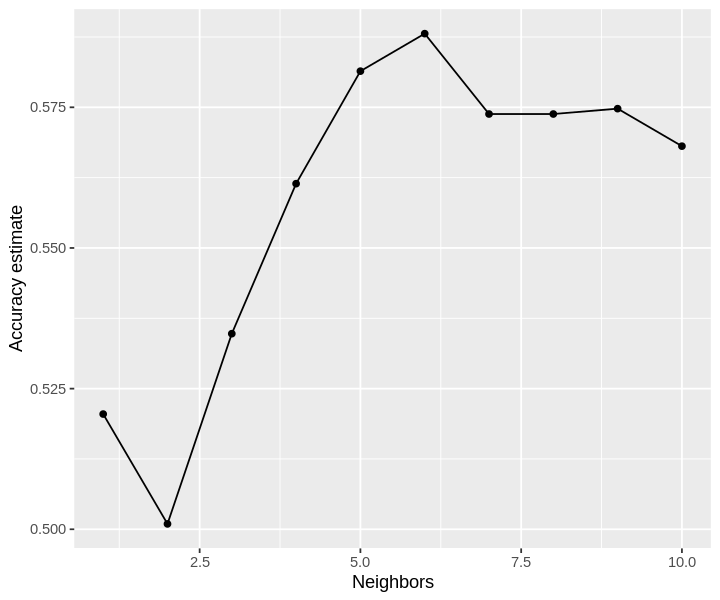

In [59]:
heart_accuracy_plot<-ggplot(accuracies,aes(x=neighbors, y=mean))+
geom_point()+
geom_line()+
labs(x="Neighbors", y="Accuracy estimate")
options(repr.plot.height = 5, repr.plot.width = 6)
heart_accuracy_plot

Build a new model specification with the best value for K found in the above plot. 
Pass the model specification and the training data set through the fit() function. 
Use this model to predict on the test dataset and report the accuracy of the prediction. 

In [62]:
set.seed(3036)
heart_spec<-nearest_neighbor(weight_func="rectangular", neighbors=6)|>
set_engine("kknn")|>
set_mode("classification")

heart_fit<-workflow()|>
add_recipe(heart_recipe)|>
add_model(heart_spec)|>
fit(data=data_train)

heart_prediction<-predict(heart_fit, data_testing)|>
bind_cols(data_testing)

heart_metrics<-heart_prediction|>
metrics(truth=condition, estimate=.pred_class)
heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.53691275
kap,binary,0.04104095


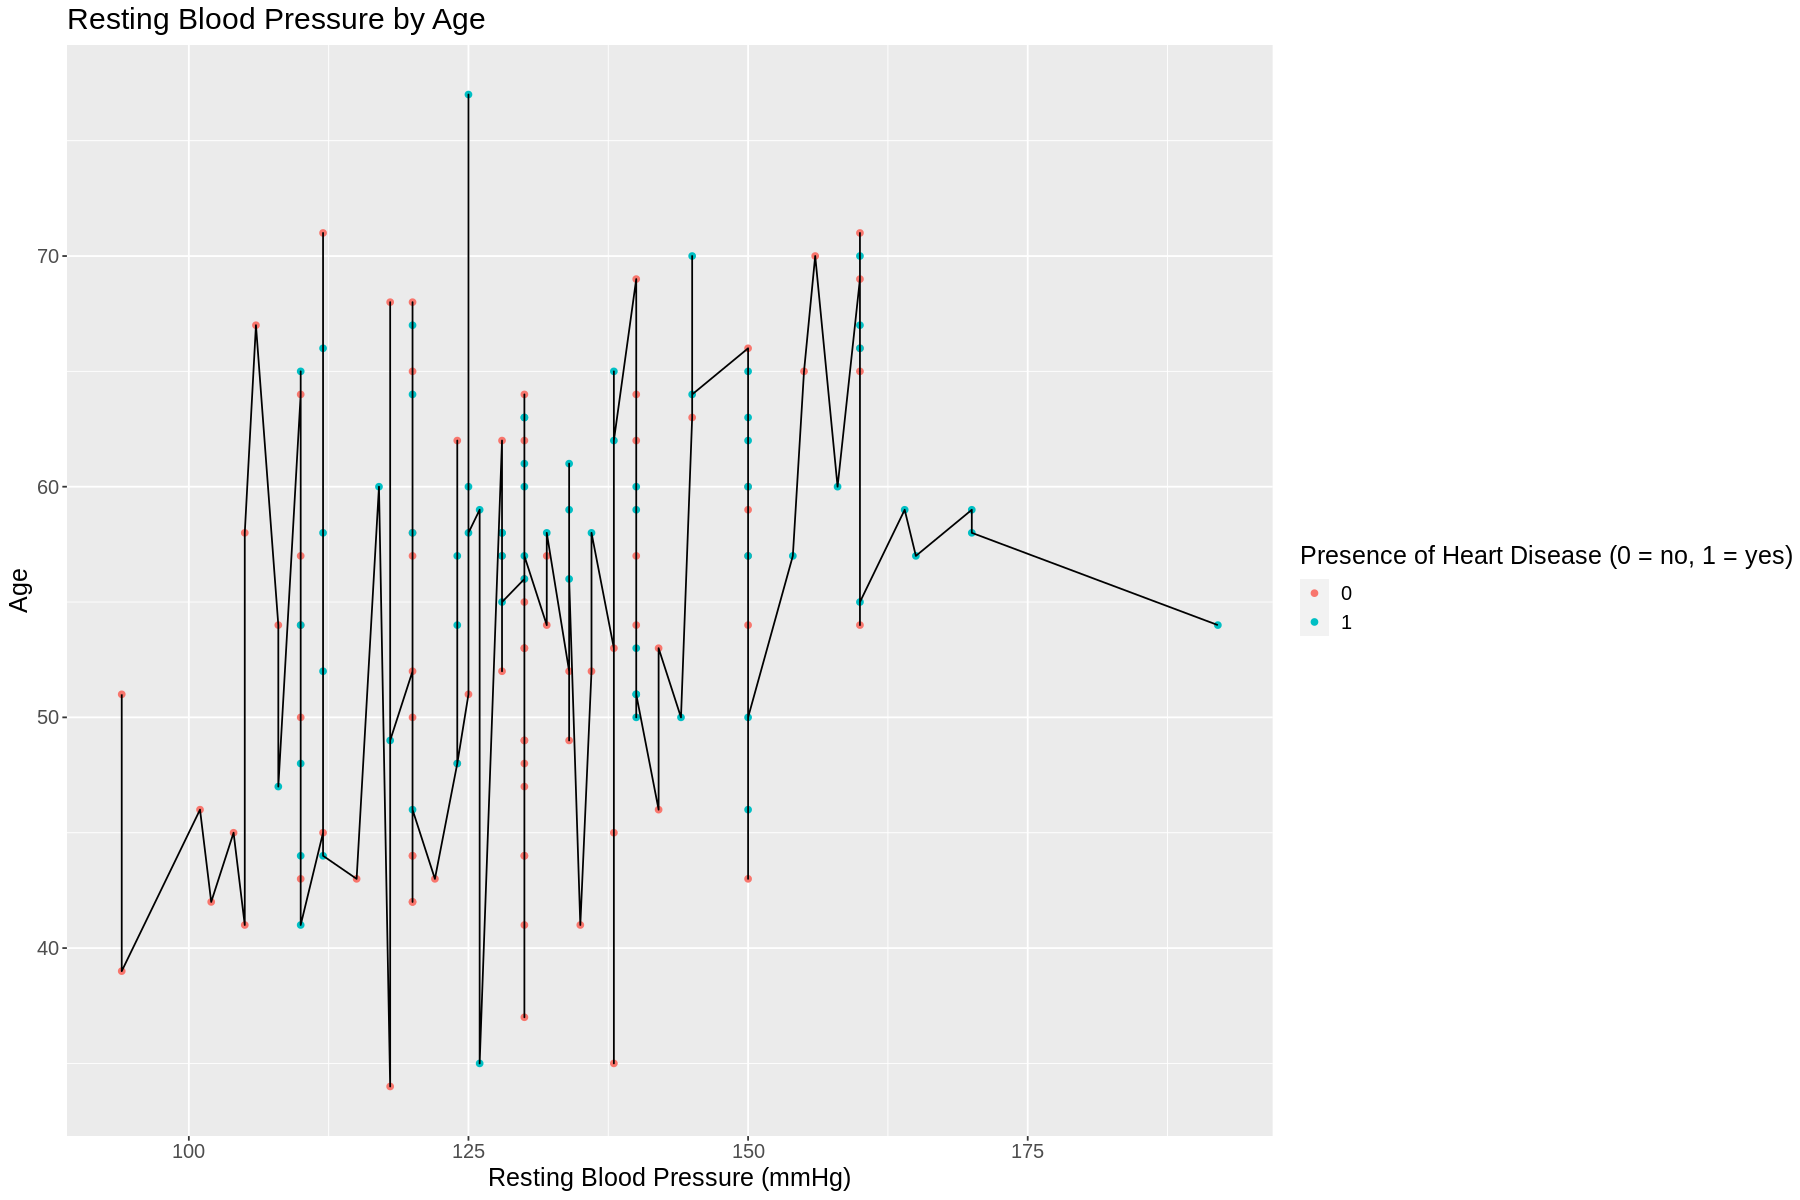

In [63]:
options(repr.plot.width = 15, repr.plot.height = 10) 
training_plot <- ggplot(data_train, aes(x=trestbps, y=age)) +
    geom_point(aes(colour=condition)) +
    geom_line() +
    ggtitle("Resting Blood Pressure by Age") +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Age", colour = "Presence of Heart Disease (0 = no, 1 = yes)") +
     theme(text = element_text(size = 15))
training_plot

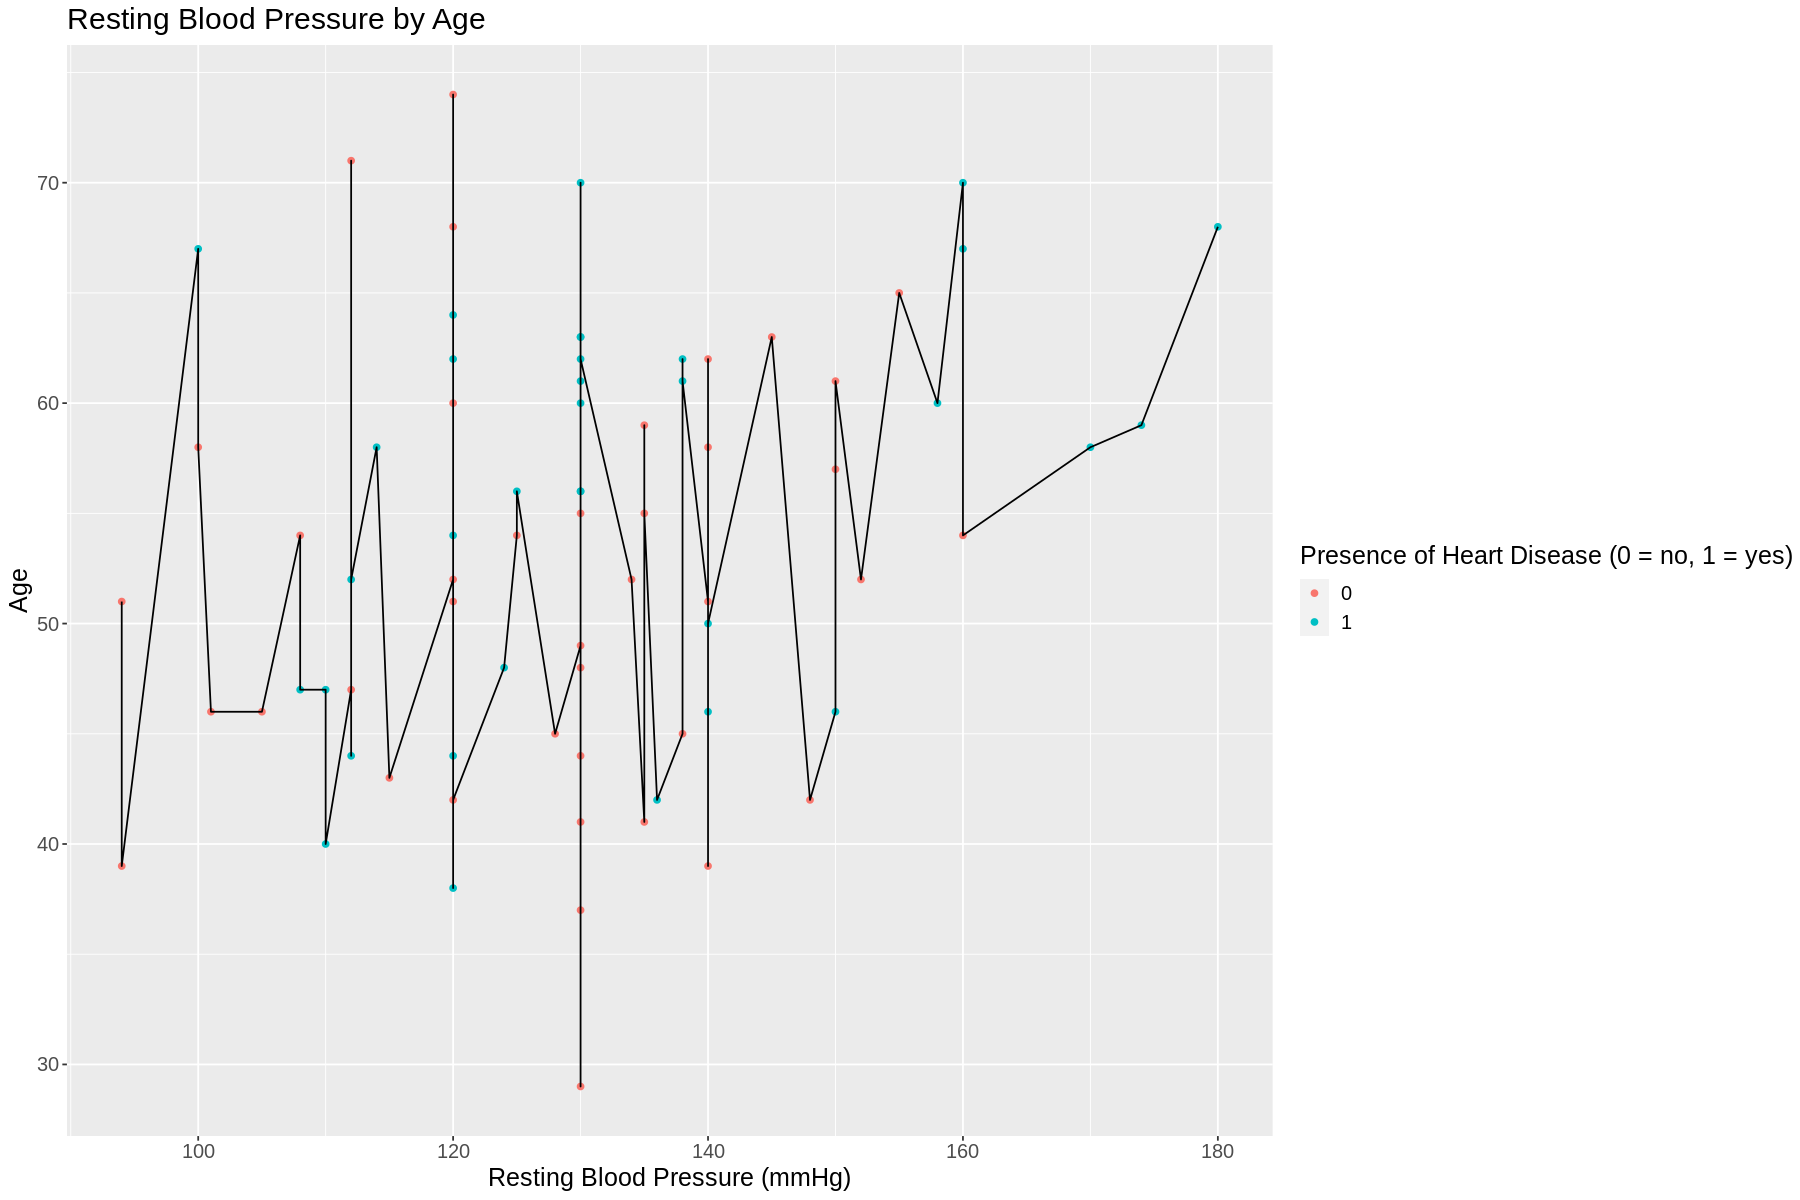

In [32]:
options(repr.plot.width = 15, repr.plot.height = 10) 
testing_plot <- ggplot(data_testing, aes(x=trestbps, y=age)) +
    geom_point(aes(colour=condition)) +
    geom_line() +
    ggtitle("Resting Blood Pressure by Age") +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Age", colour = "Presence of Heart Disease (0 = no, 1 = yes)") +
     theme(text = element_text(size = 15))
testing_plot

### Expected outcomes and Significance

All of the variables we selected (age, sex, cholesterol, fasting blood sugar, chest pain, resting ecg, resting blood pressure) are positively correlated with the likelihood of an individual having heart disease. Having a model to help predict risk of heart disease could help more people get diagnosed sooner, giving them a better prognosis. This could lead to future questions regarding what other pre-existing medical conditions can be used to predict risk of heart disease.

### Citations / References

Janosi, Andras, Steinbrunn, William, Pfisterer, Matthias, and Detrano, Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.